In [ ]:
# Project 3: Spatiotemporal Analysis with Spark (v 1.0)

In [11]:
from pyspark.sql.functions import udf
df = spark.read.load('hdfs://orion11:11001/Project3/part-*-8aab2773-5596-46be-8195-ebf00f58b617-c000.tdv.gz'
                     , format='csv', sep='\t'
                     , inferSchema='true'
                     , header='true')

In [12]:
import pygeohash as pgh
import pyspark.sql.functions as F
geohashEncodeUDF = F.udf(lambda x, y: pgh.encode(x, y))

df = df.withColumnRenamed('1_time', 'time').withColumnRenamed('2_lat', 'lat').withColumnRenamed('3_lon', 'lon').withColumnRenamed('_c18', 'geohash')
df = df.withColumn('geohash', geohashEncodeUDF(df['lat'], df['lon']))
df.take(3)

[Row(time=1542186000000, lat=26.960126220715807, lon=-89.79374121743808, albedo_surface=6.0, precipitable_water_entire_atmosphere_single_layer=42.71665, pressure_maximum_wind=21520.148, pressure_surface=102031.266, pressure_tropopause=9503.021, relative_humidity_zerodegc_isotherm=97.0, snow_depth_surface=0.0, temperature_surface=300.1487, temperature_tropopause=199.29172, total_cloud_cover_entire_atmosphere_single_layer=100.0, total_precipitation_surface_3_hour_accumulation=1.125, vegetation_surface=0.0, visibility_surface=24100.0, wilting_point_surface=0.0, wind_speed_gust_surface=16.018291, geohash='dhb1keynn5v9'),
 Row(time=1542186000000, lat=32.309655275902315, lon=-113.53787741645212, albedo_surface=28.0, precipitable_water_entire_atmosphere_single_layer=4.716647, pressure_maximum_wind=18924.95, pressure_surface=99181.664, pressure_tropopause=16783.822, relative_humidity_zerodegc_isotherm=7.0, snow_depth_surface=0.0, temperature_surface=277.7687, temperature_tropopause=206.5917, t

In [13]:
df.createOrReplaceTempView("df_temp")

In [7]:
#Strangely Snowy: Find a location that contains snow while its surroundings do not. Why does this occur? Is it a 
#high mountain peak in a desert?
snow_covered_locations = spark.sql("select distinct(geohash) from df_temp where snow_depth_surface > 0").collect()

# for row in snow_covered_locations:
#     print(row.geohash)

In [15]:
for row in snow_covered_locations:
    snowy = False
    length = len(row.geohash)
    substring = row.geohash[0: 2] 
    query = "SELECT DISTINCT(geohash) FROM df_temp WHERE geohash LIKE '" + substring + "%' AND geohash != '" + row.geohash + "'"
    neighbor_locations = spark.sql(query).collect()

    neighbor = False
    for neighbor in neighbor_locations:
        neighbor = True
        query = "SELECT count(*) FROM df_temp WHERE geohash = '" + neighbor.geohash + "' AND snow_depth_surface > 0.0 HAVING count(*) > 0"
        count = spark.sql(query).collect()

        if(len(count) > 0):
            snowy = True
            break 
       
   
    if (snowy == False and neighbor == True):
        print("strangely snowy place found")
        print("cold place " + row.geohash)
        break;


strangely snowy place found
cold place f2r487vvgzuf


In [8]:
details_of_location = spark.sql("select * from df_temp where geohash ='f2r487vvgzuf'").collect()
# print(details_of_location)

TimeTaken to execute query: 1hr 23 mins
The point is around Eagle Lake, ME, hence it is snowy. Eagle Lake is located in northern Maine, which experiences cold winters with significant snowfall. The region's climate is classified as a continental climate, characterized by cold winters and warm summers. The average snowfall in this area can vary.


In [19]:
#Climate Chart: Given a Geohash prefix as an input, build a function that will create a climate chart for the region.
#This includes high, low, and average temperatures, as well as monthly average rainfall (precipitation). Here’s a 
#(poor quality) script that will generate this for you, but you should probably modify it to make sure your units, 
#scale, etc. are all presented in a readable fashion.

# '9q8y' San Francisco
climatechart = spark.sql( "SELECT  \
                            MONTH(FROM_UNIXTIME(time/1000)) as month, \
                            min(temperature_surface) as mintemperature, \
                            max(temperature_surface) as maxtemperature, \
                            avg(temperature_surface) as windspeed, \
                            avg(precipitable_water_entire_atmosphere_single_layer) as avgprecipitation \
                        FROM df_temp \
                        WHERE \
                            geohash like '9q8y%' \
                        GROUP BY \
                            MONTH(FROM_UNIXTIME(time/1000)) order by month").collect()


In [20]:
for row in climatechart:
    print(f"{row.month} {row.maxtemperature} {row.mintemperature} {row.avgprecipitation} {row.windspeed}")

1 287.31268 280.58478 18.122153010869567 286.09792543478255
2 294.08905 279.73398 10.51255908181818 285.0857968181818
3 298.1007 280.39893 13.227399359183677 285.6007559183673
4 288.70123 283.14417 14.7388813106383 286.1134661702128
5 299.49 284.91513 18.91990586065574 287.0655240983607
6 293.3207 285.35416 14.831884346938775 287.5678455102041
7 302.7684 286.11072 22.12117175510204 289.31127775510197
8 301.43997 286.58633 17.377214108695654 289.50044565217394
9 298.28876 285.82037 14.924881104545454 288.94066181818175
10 297.72638 285.5869 18.479864312765958 289.39579106382973
11 294.27374 282.37433 15.484264729268292 288.22323902439024
12 288.9798 279.8313 16.559842177777774 286.841882


In [14]:
# Travel Startup: After graduating from USF, you found a startup that aims to provide personalized travel itineraries 
# using big data analysis. Given your own personal preferences, build a plan for a year of travel across 5 locations.
# Or, in other words: pick 5 regions. What is the best time of year to visit them based on the dataset?
# Part of this involves determining the comfort index for a region. You could incorporate several features: not too hot,
# not too cold, dry, humid, windy, etc. There are several different ways of calculating this available online, and you 
# could also analyze how well your own metrics do.
# Another part of this involves presentation. You have to convince your potential customers that your travel itinerary 
# is better than something they could come up with themselves with a little Googling. You can use pictures, information 
# about local points of interest, etc.

relative_humidity_zerodegc_isotherm = 45
temperature_surface = 299
total_cloud_cover_entire_atmosphere = 60 
# Grand canyon 9qrhf6btbt3jevhn
# Panhandle san francisco 9q8yvs4t
# New york dr5regw2z6y
# Fresno 9qd23ynghrrz
# Colorado 9x58

traveldata = spark.sql( "SELECT  \
                            substring(geohash, 0, 4) as region, \
                            MONTH(FROM_UNIXTIME(time/1000)) as month, \
                            AVG(temperature_surface) as temperature, \
                            AVG(relative_humidity_zerodegc_isotherm) as humdity, \
                            AVG(wind_speed_gust_surface) as windspeed, \
                            AVG(total_cloud_cover_entire_atmosphere_single_layer) as cloudcover \
                        FROM df_temp \
                        WHERE \
                            Geohash like '9qd2%' or \
                            Geohash like 'dr5r%' or \
                            Geohash like '9q8y%' or \
                            Geohash like '9qrh%' or  \
                            Geohash like '9x58%'  \
                        GROUP BY \
                            MONTH(FROM_UNIXTIME(time/1000)), \
                            substring(geohash, 0, 4)").collect()

In [15]:
import folium
from pygeohash import decode
relative_humidity_zerodegc_isotherm = 45
temperature_surface = 299
total_cloud_cover_entire_atmosphere = 60 
region = set()
for row in traveldata:
    isgood = True
    if(row.temperature < (temperature_surface - (temperature_surface * .10)) or  
       row.temperature > (temperature_surface + (temperature_surface * .10))):
        isgood = False
    if(row.humdity < (relative_humidity_zerodegc_isotherm - (relative_humidity_zerodegc_isotherm * .25)) or  
       row.humdity > (relative_humidity_zerodegc_isotherm + (relative_humidity_zerodegc_isotherm * .25))):
        isgood = False
    if(row.cloudcover < (total_cloud_cover_entire_atmosphere - (total_cloud_cover_entire_atmosphere * .50)) or  
       row.cloudcover > (total_cloud_cover_entire_atmosphere + (total_cloud_cover_entire_atmosphere * .50))):
        isgood = False
    if(isgood == True) and len(region) <= 5 :
        print(f"{row.region} {row.month} ")
        region.add(row.region)
        
t = folium.Map(location=[37.0902, -95.7129], zoom_start=4)


for g in region:
    # Extract the latitude and longitude from the geohash
    lat, lon = decode(g)    
    # Add a marker to the map at the geohash location
    folium.Marker(location=[lat, lon], popup=g).add_to(t)
t

dr5r 8 
9qrh 12 
9qd2 12 
9q8y 11 
9qd2 1 
9q8y 1 
dr5r 6 
9qrh 1 
9q8y 12 
9q8y 5 
9qd2 3 
9qrh 3 
9q8y 7 
9x58 9 
dr5r 7 
dr5r 5 
9q8y 4 
9q8y 3 
dr5r 10 


In [ ]:
# We use five specific locations (Arizona, San Francisco, New York, Fresno, and Colorado) for travel predictions. Our 
# prediction parameters include temperature, cloud cover, and humidity. We compare the monthly average values of these
# parameters in each region using the first four characters of their geohash. To make predictions, we compare the 
# average values with predefined criteria. The temperature should fall within a 10% range, humidity within 25% of our 
# specified value, and cloud cover within 50% of our value. Based on these comparisons, we assess the suitability of 
# the locations for travel according to the given criteria.

# Grand canyon Arizona(9qrh) - December, January, March
# Panhandle san francisco(9q8y) - November, December, May, April, March, July, January
# New york (dr5r) - May, October, August, June
# Fresno (9qd2) - December, January, March
# Colorado (9x58) - September

In [17]:
# Escaping the fog: After becoming rich from your startup, you are looking for the perfect location to build your Bay 
# Area mansion with unobstructed views. Find the locations that are the least foggy and show them on a map.
from IPython.display import display, HTML
from pygeohash import decode
import folium


fogResult = spark.sql("SELECT geohash, \
                              AVG(visibility_surface) as visSurface, \
                              AVG(albedo_surface) as avgSurface, \
                              wilting_point_surface \
                       FROM df_temp \
                       WHERE (geohash LIKE '9q8y%' \
                          OR geohash LIKE '9q8z%' \
                          OR geohash LIKE '9q9h%' \
                          OR geohash LIKE '9q9k%' \
                          OR geohash LIKE '9q9m%' \
                          OR geohash LIKE '9q9p%' \
                          OR geohash LIKE '9q8v%' \
                          OR geohash LIKE '9q9n%') \
                          AND (wilting_point_surface > 0.0) \
                       GROUP BY geohash, wilting_point_surface \
                       ORDER BY avgSurface desc, visSurface desc").collect()

cordinates_list = []
i = 0

for x in fogResult:
#     print(fogResult[i][0]," ",fogResult[i][1]," " ,fogResult[i][2]," ",fogResult[i][3])
    cordinates_list.append(decode(fogResult[i][0]))
    i += 1
print(cordinates_list) 

      
m = folium.Map(location=[37.491989, -121.952673], zoom_start=10)

# Add markers for each set of coordinates
for coord in cordinates_list:
    folium.Marker(coord).add_to(m)

# Display the map
m

[(37.491989, -121.952673), (37.513057, -121.820522), (37.323334, -122.321857), (37.344703, -122.189984), (37.365968, -122.058057), (37.408186, -121.794052), (37.42914, -121.661969), (37.596798, -121.979318), (37.387129, -121.92608), (37.534022, -121.688315), (37.701559, -122.006016), (37.303266, -121.767633), (37.80627, -122.032765), (37.282221, -121.899539), (37.910929, -122.059566), (37.680363, -122.138363), (37.889711, -122.192162), (37.785063, -122.165236), (37.951537, -122.484425), (37.929995, -122.616986), (37.825431, -122.589635), (37.846961, -122.457198), (37.63766, -122.402903), (37.532933, -122.375835)]


In [34]:
# SolarWind, Inc.: After getting rich from your travel startup you get bored and start a new company; here, you want to 
#     help power companies plan out the locations of solar and wind farms across North America. Locate the top 3 places 
#     for solar and wind farms, as well as a combination of both (solar + wind farm). You will report a total of 9 
#     Geohashes as well as their relevant attributes (for example, cloud cover and wind speeds).
solarFarms = spark.sql("SELECT \
                            SUBSTRING(geohash,1,6) as prefix, \
                            AVG(CAST(total_cloud_cover_entire_atmosphere_single_layer AS DECIMAL(10,2))) as cloudCover, \
                            wilting_point_surface \
                        FROM df_temp \
                        WHERE (geohash LIKE 'c%' or geohash LIKE '9%') and  wilting_point_surface > 0.0 \
                        GROUP BY prefix, wilting_point_surface \
                        ORDER BY cloudCover").collect()

print("Top three solar farms")
print("Geohash:" + str(solarFarms[0][0]) + ", Avg total_cloud_cover_entire_atmosphere_single_layer: " + str(solarFarms[0][1]))
print("Geohash:" + str(solarFarms[1][0]) + ", Avg total_cloud_cover_entire_atmosphere_single_layer: " + str(solarFarms[1][1]))
print("Geohash:" + str(solarFarms[2][0]) + ", Avg total_cloud_cover_entire_atmosphere_single_layer: " + str(solarFarms[2][1]))



windFarms = spark.sql("SELECT \
                            SUBSTRING(geohash,1,6) as prefix, \
                            AVG(wind_speed_gust_surface) as avgWind, \
                            wilting_point_surface \
                        FROM df_temp \
                        WHERE (geohash LIKE 'c%' or geohash LIKE '9%') and  wilting_point_surface > 0.0 \
                        GROUP BY prefix, wilting_point_surface \
                        ORDER BY avgWind desc").collect()

print("Top three wind farms")
print("Geohash:" + str(windFarms[0][0]) + ", Avg wind_speed_gust_surface: " + str(windFarms[0][1]))
print("Geohash:" + str(windFarms[1][0]) + ", Avg wind_speed_gust_surface: " + str(windFarms[1][1]))
print("Geohash:" + str(windFarms[2][0]) + ", Avg wind_speed_gust_surface: " + str(windFarms[2][1]))

maxWindSpeed = spark.sql("SELECT MAX(wind_speed_gust_surface) FROM df_temp").collect()

windAndSolarFarms = spark.sql(f"SELECT \
                                     SUBSTRING(geohash,1,6) as prefix, \
                                     AVG(wind_speed_gust_surface) as avgWind, \
                                     AVG(CAST(total_cloud_cover_entire_atmosphere_single_layer AS DECIMAL(10,2))) as cloudCover, \
                                     wilting_point_surface \
                                 FROM df_temp \
                                 WHERE (geohash LIKE 'c%' or geohash LIKE '9%') and  wilting_point_surface > 0.0 \
                                 GROUP BY prefix, wilting_point_surface \
                                 ORDER BY ((avgWind/ {maxWindSpeed[0][0]} )*100)*cloudCover desc").collect()

first = windAndSolarFarms[0]
second = windAndSolarFarms[1]
third = windAndSolarFarms[2]

print("Top three wind and solar farms")
print("Geohash:" + str(first[0]) + ", Score:", str(first[1]/maxWindSpeed[0][0]*100 * float((first[2]))))
print("Geohash:" + str(second[0]) + ", Score:", str(second[1]/maxWindSpeed[0][0]*100 * float((second[2]))))
print("Geohash:" + str(third[0]) + ", Score:", str(third[1]/maxWindSpeed[0][0]*100 * float((third[2]))))

Top three solar farms
Geohash:9mtzhd, Avg total_cloud_cover_entire_atmosphere_single_layer: 4.973684
Geohash:9mv6vz, Avg total_cloud_cover_entire_atmosphere_single_layer: 5.635659
Geohash:9mwh9p, Avg total_cloud_cover_entire_atmosphere_single_layer: 5.769231


Top three wind farms
Geohash:9xkzng, Avg wind_speed_gust_surface: 10.506980859999999
Geohash:9xsc6w, Avg wind_speed_gust_surface: 10.409824772481203
Geohash:9xmnd4, Avg wind_speed_gust_surface: 10.40498561470588


Top three wind and solar farms
Geohash:c19ewq, Score: 1180.430376615631
Geohash:c196jz, Score: 1166.7002720722528
Geohash:c1c1pw, Score: 1155.0288341570981


In [ ]:
# Weather Station: Write a multi-threaded server (outside of Spark) that reads files from the dataset — one file per 
# thread — and then streams them out on a socket for a Spark streaming context to consume (note: not ALL the 
# files have to be opened at once! :-)). The program should produce records as fast as the network will support, i.e., 
# faster than real time. Using Spark, consume the streams and then:

# Choose five geographical locations to aggregate. You will filter out any other locations present in the streams.
# Build an online summary of surface temperature, pressure, humidity, precipitation, visibility, and wind speed for the
# geographical locations you selected.Produce a visual overview of these summaries. You have freedom to show the data 
# however you’d like, but the idea here is to give the viewer a high-level summary of the weather in different locations
# and how it is changing in real time (well, actually faster than real time in this case!). A basic approach could be to
# show each metric separately on a 5-by-6 grid. Your visualization should either update in place in the Jupyter notebook
# as data arrives, or you can build a video by exporting each frame of the visualization to a file and then combining 
# them.Turn in a video of your weather station in action.



In [ ]:
# We created server.go and tried to connect to the spark streaming but didnt work for us.

In [45]:
# Prediction/Classification: Revisit any of the problems above and enhance them using machine learning models from 
# MLlib. You will need to explain:
# The feature you will predict/classify
# Features used to train the model
# How you partitioned your data
# How the prediction/classification improves your analysis

from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(df,
    [ 
     "albedo_surface", 
     "vegetation_surface",
     "relative_humidity_zerodegc_isotherm",
     "total_precipitation_surface_3_hour_accumulation",
     "temperature_surface"
    ],
    "snow_depth_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.8, 0.2])

+--------------------+------+
|            features| label|
+--------------------+------+
|[19.3,1.0,17.0,0....|   0.0|
|[17.0,13.0,40.0,0...|4.0E-5|
|[20.3,26.9,13.0,0...|   0.0|
|[6.0,0.0,23.0,0.0...|   0.0|
|[16.0,18.4,14.0,0...|   0.0|
|[13.9,28.2,18.0,0...|   0.0|
|[17.3,25.1,12.0,0...|   0.0|
|[18.3,31.0,35.0,0...|   0.0|
|[19.6,28.1,22.0,0...|   0.0|
|[6.0,0.0,10.0,0.0...|   0.0|
|[18.7,26.0,24.0,0...|   0.0|
|[17.6,17.9,14.0,0...|   0.0|
|[17.0,6.0,39.0,0....|   0.0|
|[6.0,0.0,19.0,0.0...|   0.0|
|[25.5,8.1,55.0,0....|   0.0|
|[6.0,0.0,5.0,0.0,...|   0.0|
|[17.0,1.0,29.0,0....|   0.0|
|[22.7,1.0,14.0,0....|   0.0|
|[23.9,15.0,30.0,0...|   0.0|
|[17.0,9.0,34.0,0....|   0.0|
+--------------------+------+
only showing top 20 rows



In [46]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.0170701


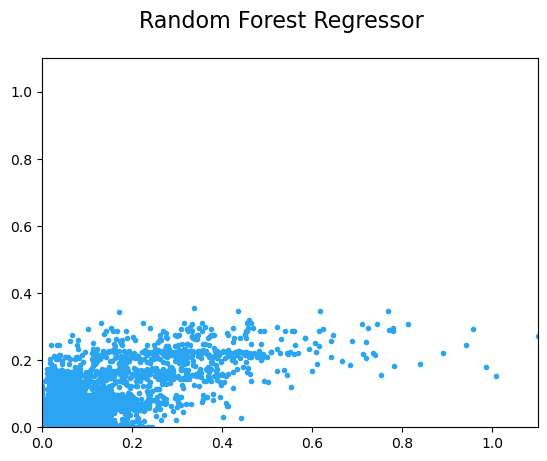

In [47]:

import matplotlib.pyplot as plt

p_df = predictions.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()


In [ ]:
# Q.) The feature you will predict/classify: "snow_depth_surface"
# Q.) Features used to train the model: "albedo_surface" 
#                                       "vegetation_surface"
#                                       "relative_humidity_zerodegc_isotherm"
#                                       "total_precipitation_surface_3_hour_accumulation"
#                                       "temperature_surface"
# Q.) How you partitioned your data: 80% for training and 20% for testing
# Q.) How the prediction/classification improves your analysis: Based on the regression analysis conducted, 
#     which yielded a root mean square error (RMSE) of 0.0170701, we have developed a predictive model to estimate
#     the snow depth for any new incoming point.